In [29]:
#do not change
import sys
import os
from time import time
%matplotlib inline
from urllib.request import urlopen
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
#from scipy.misc import imsave
import math
  
def load_mnist():
    images_url = 'https://github.com/guptashvm/Data/blob/master/data/train-images-idx3-ubyte?raw=true'
    with urlopen(images_url) as urlopened:
      fd = urlopened.read()
      loaded = np.frombuffer(fd,dtype=np.uint8)
      trX = loaded[16:].reshape((60000,28*28)).astype(float)
 
    labels_url = 'https://github.com/guptashvm/Data/blob/master/data/train-labels-idx1-ubyte?raw=true'
    with urlopen(labels_url) as urlopened:
      fd = urlopened.read()
      loaded = np.frombuffer(fd,dtype=np.uint8)
      trY = loaded[8:].reshape((60000))
 
    trY = np.asarray(trY)
 
    X = trX / 255.
    y = trY
 
    subset  = [i for i, t in enumerate(y) if t in [1, 0, 2, 3]]
    X, y = X.astype('float32')[subset], y[subset]
    return X[:1000], y[:1000]

Run the following code to load the data we need. Here, **X** is the array of images, **y** is the array of labels, and **X2d** is the array of projections of the images into two-dimensional space using PCA. The two-dimensional scatterplot of the top two principal components of the images is displayed, where the color of each point represents its label. 

## NOTE TO PEER-REVIEWERS
There was an error in the base notebook in which the data was not correctly projected onto the top two principal components. Below we have displayed the differences. **Plots that look like either of these are okay.**

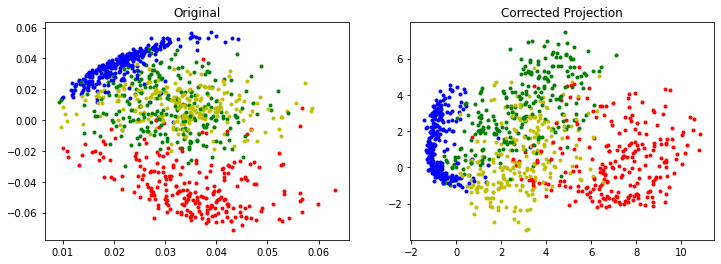

In [43]:
X, y = load_mnist()
pca = PCA(n_components=2)
pca.fit(X.T)
X2d_orig = pca.components_.T
pca.fit(X)
X2d_correct = X.dot(pca.components_.T)

def plot_with_colors(Xs_orig, Xs_correct, ys, new_ys=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    if new_ys is None:
        new_ys = ys
        
    for i, _ in enumerate(ys):
        if ys[i] == 0:
            ax1.plot([Xs_orig[i, 0]], [Xs_orig[i, 1]], 'r.')
        elif ys[i] == 1:
            ax1.plot([Xs_orig[i, 0]], [Xs_orig[i, 1]], 'b.')
        elif ys[i] == 2:
            ax1.plot([Xs_orig[i, 0]], [Xs_orig[i, 1]], 'g.')
        elif ys[i] == 3:
            ax1.plot([Xs_orig[i, 0]], [Xs_orig[i, 1]], 'y.')
            
        if new_ys[i] == 0:
            ax2.plot([Xs_correct[i, 0]], [Xs_correct[i, 1]], 'r.')
        elif new_ys[i] == 1:
            ax2.plot([Xs_correct[i, 0]], [Xs_correct[i, 1]], 'b.')
        elif new_ys[i] == 2:
            ax2.plot([Xs_correct[i, 0]], [Xs_correct[i, 1]], 'g.')
        elif new_ys[i] == 3:
            ax2.plot([Xs_correct[i, 0]], [Xs_correct[i, 1]], 'y.')
            
    ax1.set_title("Original")
    ax2.set_title("Corrected Projection")
    plt.show()

plot_with_colors(X2d_orig, X2d_correct, y)

(a) Implement the standard k-means algorithm. Please complete the function __kmeans__ defined below. You are NOT allowed to use any existing code of **kmeans** for this problem.

In [42]:
def kmeans(X, k = 4, max_iter = 500, random_state=0):
  """
  Inputs:
      X: input data matrix, numpy array with shape (n * d), n: number of data points, d: feature dimension
      k: number of clusters
      max_iters: maximum iterations
  Output:
      clustering label for each data point
  """
  assert len(X) > k, 'illegal inputs'
  np.random.seed(random_state)

  # randomly select k data points as centers
  idx = np.random.choice(len(X), k, replace=False)
  centers = X[idx]

  # please complete the following code: 

  from scipy.spatial import distance
  for i in range(max_iter):
      H = distance.cdist(X, centers, 'euclidean')
      labels = np.argsort(H, 1)[:, 0]
      for c in range(k):
          subset = np.where(labels == c)[0]
          centers[c] = np.mean(X[subset], 0)
      # labels = update clustering labels 
      # update new centers

  return labels

(b) Run your **kmeans** function on the dataset (of the top two PCA components given by array X2d). Set the number of clusters to 4. Visualize the result by coloring the 2D points in (a) according to their **clustering labels** returned by your **kmeans** algorithm. Because **kmeans** is sensitive to initialization, repeat your **kmeans** at least 5 times with different random initializations and show the plot of each initialization.

To quantitatively evaluate the clustering performance, we evaluate the $\textit{unsupervised clustering accuracy}$, which can be written as follows,
$$
\text{accuracy} = \max_{\mathcal M} \frac{\sum_{i=1}^{n} \mathbb{I}(y_i = \mathcal M(z_i))}{n}, n = 1000,
$$
where $y_i$ is the ground-truth label, $z_i$ is the cluster assignment produced by the algorithm,
and $\mathcal M$ ranges over all possible one-to-one mapping between clusters and labels and $\mathbb{I}(x)$
is a indicator function ($\mathbb{I}(x) = 1\text{if}~x=1; \text{otherwise} ~0$).
Please use the __accuracy_score__ function defined below to calculate the accuracy.
Report the best clustering accuracy you get out of 10 random initializations. 

In [25]:
# do not change
def accuracy_score(y_true, y_pred):
    """
    Calculate clustering accuracy. 
        y_true: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    assert y_true.shape == y_pred.shape, 'illegal inputs'
 
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[row_ind[i], col_ind[i]] for i in range(len(row_ind))]) * 1.0 / y_pred.size

## PEER-GRADERS
Again, only one column of the following plots needs to be present in the student submission. Either is okay. The same is true for the accuracy scores.

**Also,** random seeds were not specified in this homework so do not take off points for answers that deviate only very slightly from these solutions.

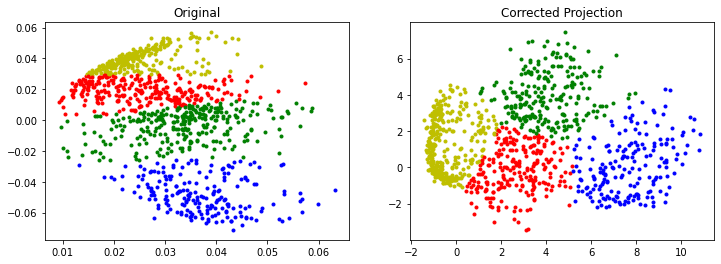

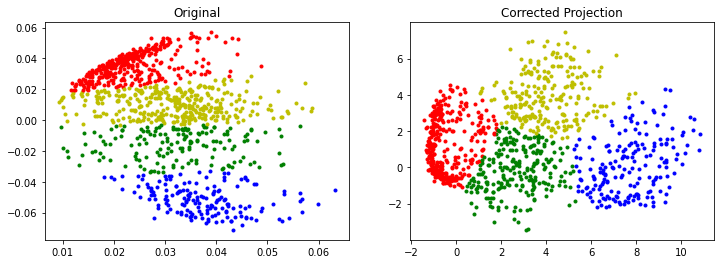

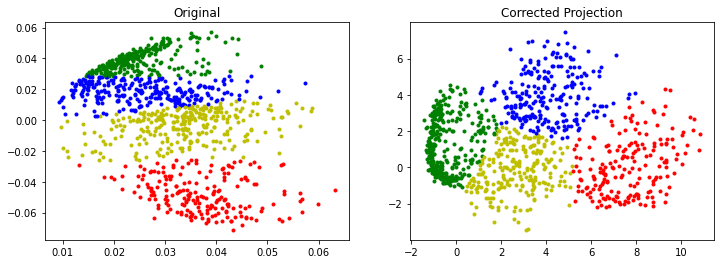

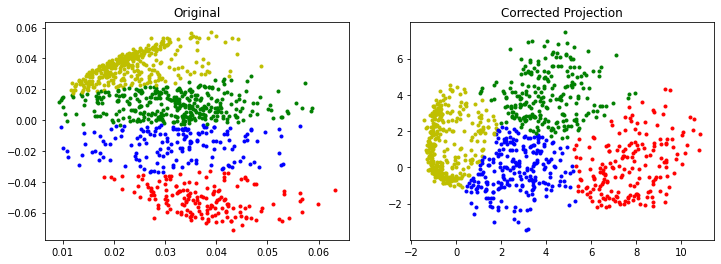

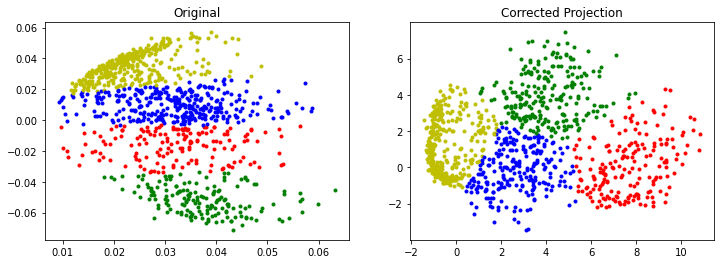

Orig: 0.634 Corrected: 0.745
Orig: 0.682 Corrected: 0.743
Orig: 0.635 Corrected: 0.745
Orig: 0.684 Corrected: 0.743
Orig: 0.681 Corrected: 0.743
Orig: 0.634 Corrected: 0.745
Orig: 0.682 Corrected: 0.745
Orig: 0.681 Corrected: 0.743
Orig: 0.634 Corrected: 0.745
Orig: 0.682 Corrected: 0.743
Best clustering accuracy: 
Original data: 0.684   With corrected projection: 0.745


In [51]:
# your code here

for i in range(5):
  labels_orig = kmeans(X2d_orig, k =4, max_iter=500, random_state=i)
  labels_correct = kmeans(X2d_correct, k =4, max_iter=500, random_state=i)
  plot_with_colors(X2d_orig, X2d_correct, labels_orig, new_ys=labels_correct)


best_acc_orig, best_acc_correct = 0, 0
for i in range(10):
    labels_orig = kmeans(X2d_orig, k=4, max_iter=500, random_state=i)
    acc_orig = accuracy_score(labels_orig, y)
    best_acc_orig = max(acc_orig, best_acc_orig)
    
    labels_correct = kmeans(X2d_correct, k=4, max_iter=500, random_state=i)
    acc_correct = accuracy_score(labels_correct, y)
    best_acc_correct = max(acc_correct, best_acc_correct)
    print("Orig:", acc_orig, "Corrected:", acc_correct)
    
print('Best clustering accuracy: ')
print("Original data:", best_acc_orig, "  With corrected projection:", best_acc_correct)

We have been testing $\textit{k}$-means on the top two principal components for the purpose of visualization. 
Please run $\textit{k}$-means on the  (784 dimensional) original image dataset (again using 4 clusters). 
Try at least 10 different random initializations and report the best accuracy as above.

In [49]:

# enter your code here
best_acc = 0
for i in range(10):
  labels = kmeans(X, k=4, max_iter=500, random_state=i)
  acc = accuracy_score(labels, y)
  best_acc = max(acc, best_acc)
print('Best clustering accuracy: ', best_acc)

Best clustering accuracy:  0.861
